# Neural Network on labelled *.pcap

### Set-Up

In [104]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import collections
import seaborn as sns
from pprint import pprint
import os
import json
import shutil

# import ipywidgets
# import warnings

# import pyshark
# import networkx as nx

# from sklearn.preprocessing import OrdinalEncoder, StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.manifold import TSNE
# from sklearn.metrics import pairwise_distances, silhouette_score
# from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
# import umap

# from itertools import product

# PATH change to access library cyberlib
import sys
sys.path.append('/home/benjamin/Folders_Python/Cyber/libs')
import cyberlib as cbl

# to allow PyShark to run in Jupyter notebooks
# import nest_asyncio
# nest_asyncio.apply()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

### Logging set-up

In [3]:
# logging set-up

lg = cbl.GetLogger('/home/benjamin/Folders_Python/Cyber/logs/model.log')
logger = lg.get_custom_logger()

# start your engine
logger.info("-------- new run --------")

### Import *.csv into dataframe

In [68]:
# which *.csv
DFNAME = 'smallFlows'  # *.csv file to import

DATA_INPUT = '/home/benjamin/Folders_Python/Cyber/data/dataframes/'
CSVFILE = DATA_INPUT + 'df_' + DFNAME + '.csv'

In [69]:
with open(CSVFILE, 'r') as f:
    df_origin = pd.read_csv(f, header=0)

In [70]:
# clean-up

columns_to_drop = [
    'DateTime', 'DateTime.1', 'frame.number'
]

df = df_origin.drop(columns=columns_to_drop)

In [71]:
df

,eth.src,eth.dst,ip.src_host,ip.dst_host,ip.len,ip.hdr_len,ip.ttl,tcp.srcport,tcp.dstport,tcp.stream,tcp.len,tcp.seq,tcp.ack,tcp.hdr_len,tcp.time_relative,tcp.time_delta,tcp.flags,y
0,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,192.168.3.131,72.14.213.138,983,20,128,57011,80,0,943,1,1,20,0.000000,0.000000,0x0018,2
1,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,72.14.213.138,192.168.3.131,426,20,52,80,57011,0,386,1,944,20,0.029841,0.029841,0x0018,0
2,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,192.168.3.131,72.14.213.102,52,20,128,55950,80,1,0,0,0,32,0.000000,0.000000,0x0002,0
3,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,192.168.3.131,72.14.213.138,40,20,128,57011,80,0,0,944,387,20,0.229423,0.199582,0x0010,0
4,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,72.14.213.102,192.168.3.131,52,20,52,80,55950,1,0,0,1,32,0.018766,0.018766,0x0012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13703,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,65.55.15.244,40,20,128,2537,5480,407,0,5039,5738,20,71.195375,66.560501,0x0014,0
13704,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,207.46.105.186,40,20,128,2540,5480,409,0,398,93,20,70.606228,5.540471,0x0014,0
13705,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,96.17.8.49,40,20,128,2547,5480,419,0,496,8189,20,64.405045,64.259982,0x0014,0
13706,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,91.103.140.2,40,20,128,2546,5480,417,0,525,270,20,64.884164,64.357688,0x0014,0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13708 entries, 0 to 13707
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   eth.src            13708 non-null  object 
 1   eth.dst            13708 non-null  object 
 2   ip.src_host        13708 non-null  object 
 3   ip.dst_host        13708 non-null  object 
 4   ip.len             13708 non-null  int64  
 5   ip.hdr_len         13708 non-null  int64  
 6   ip.ttl             13708 non-null  int64  
 7   tcp.srcport        13708 non-null  int64  
 8   tcp.dstport        13708 non-null  int64  
 9   tcp.stream         13708 non-null  int64  
 10  tcp.len            13708 non-null  int64  
 11  tcp.seq            13708 non-null  int64  
 12  tcp.ack            13708 non-null  int64  
 13  tcp.hdr_len        13708 non-null  int64  
 14  tcp.time_relative  13708 non-null  float64
 15  tcp.time_delta     13708 non-null  float64
 16  tcp.flags          137

### EDA

In [85]:
# tcp streams
print(f"Number of TCP streams = {len(df['tcp.stream'].unique())}")

# Ethernet and IP sources and destinations
print(f"Number of Ethernet sources = {len(df['eth.src'].unique())}")
print(f"Number of Ethernet destinations = {len(df['eth.dst'].unique())}")
print(f"Number of IP sources = {len(df['ip.src_host'].unique())}")
print(f"Number of IP destinations = {len(df['ip.dst_host'].unique())}")

# ports
print(f"Number of source ports = {len(df['tcp.srcport'].unique())}")
print(f"Number of destination ports = {len(df['tcp.dstport'].unique())}")

# flags
print(f"Number of flags signatures = {len(df['tcp.flags'].unique())}")

# alerts
y = df['y'].to_numpy()
y = np.where(y>=1, 1, 0)
n_alerts = np.sum(y)
print(f"Number of alerts = {n_alerts}")

Number of TCP streams = 485
Number of Ethernet sources = 7
Number of Ethernet destinations = 7
Number of IP sources = 106
Number of IP destinations = 110
Number of source ports = 437
Number of destination ports = 416
Number of flags signatures = 8
Number of alerts = 48


In [81]:
df.columns

Index(['eth.src', 'eth.dst', 'ip.src_host', 'ip.dst_host', 'ip.len',
       'ip.hdr_len', 'ip.ttl', 'tcp.srcport', 'tcp.dstport', 'tcp.stream',
       'tcp.len', 'tcp.seq', 'tcp.ack', 'tcp.hdr_len', 'tcp.time_relative',
       'tcp.time_delta', 'tcp.flags', 'y'],
      dtype='object')

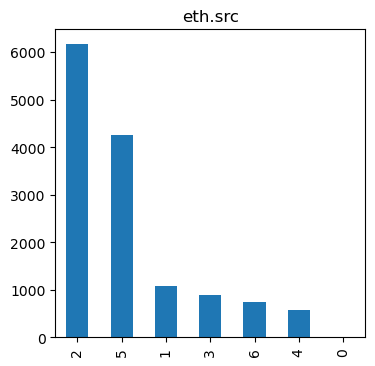

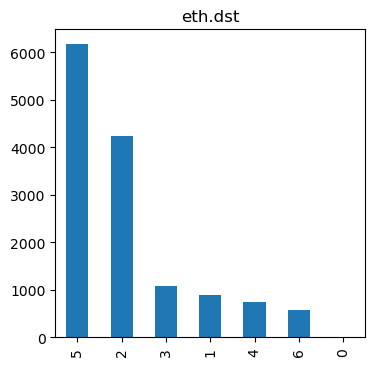

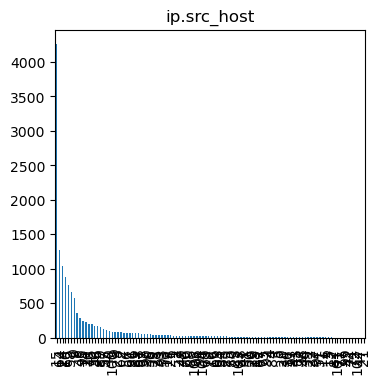

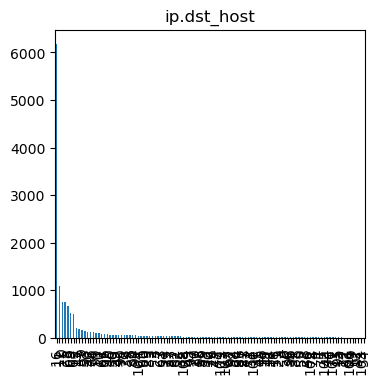

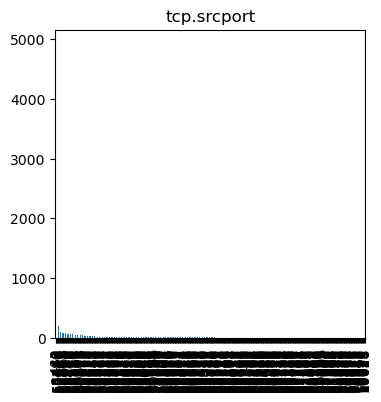

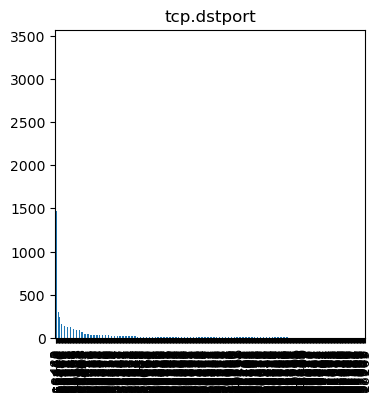

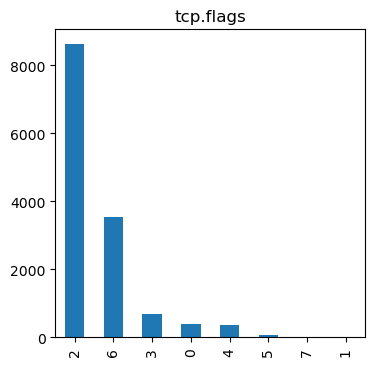

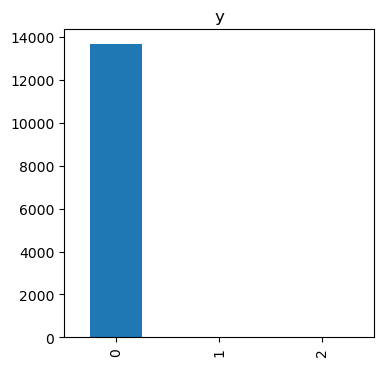

In [95]:
columns_for_barplots = ['eth.src', 'eth.dst', 'ip.src_host', 'ip.dst_host', 
       'tcp.srcport', 'tcp.dstport', 
       'tcp.flags', 'y']

for c in columns_for_barplots:
    fig, ax = plt.subplots(figsize=(4,4))
    ax = df[c].value_counts().plot.bar()
    ax.set_title(c)
    
plt.show()

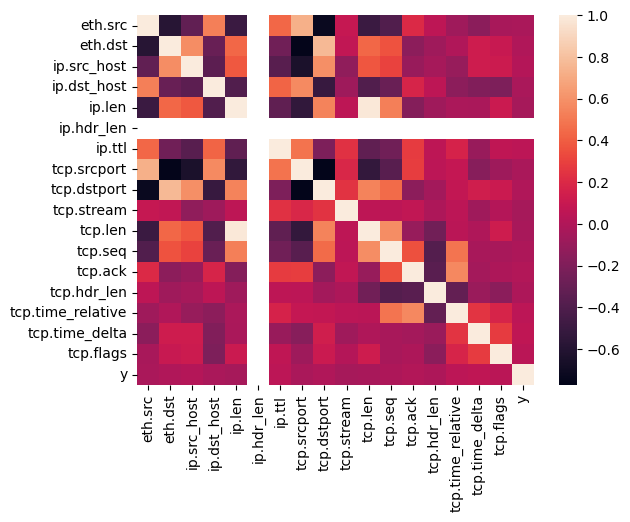

In [103]:
# correlation

df_corr = df.copy()
object_columns = df_corr.select_dtypes(['object']).columns  # identify columns with type object
df_corr[object_columns] = df_corr[object_columns].astype('category')   # first, convert them to categorical type
df_corr[object_columns] = df_corr[object_columns].apply(lambda x : x.cat.codes)  # second, use the numerical code

corr_matrix = df_corr.corr(method='spearman') # rank correlation
sns.heatmap(corr_matrix)
plt.show()

### Dataset

In [98]:
def generate_X_y(df=df):
    """Utility function to generate full X and y out of the dataframe

    Args:
        df (panda dataframe, optional): dataframe to process. Defaults to df.
    """
    
    # handles column with type 'object'
    object_columns = df.select_dtypes(['object']).columns  # identify columns with type object
    df[object_columns] = df[object_columns].astype('category')   # first, convert them to categorical type
    df[object_columns] = df[object_columns].apply(lambda x : x.cat.codes)  # second, use the numerical code
    
    # separate y column
    y = df['y'].to_numpy()
    y = np.where(y==0, 0, 1)  # all numbers of alerts greater than one are cast to one
    
    # convert the dataframe to numpy
    X = df.drop(columns=['y']).to_numpy()
    
    return X, y    

In [99]:
X, y = generate_X_y(df)

In [109]:
# Stratified Shuffle Split to respect class imbalance
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))
X_train = X[train_idx]
X_test =X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

# scale transform train set, transform test set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [110]:
# Vérification du split

n_pos_full = len(df[df["y"]>=1])
n_neg_full = len(df[df["y"]==0])

print(f"Full dataset : there are {n_pos_full} alerts, and {n_neg_full} benign, ie {n_pos_full/(n_pos_full+n_neg_full)*100:.2f}%")

n_pos_train = np.sum(y_train)
n_neg_train = len(y_train) - n_pos_train
print(f"Training dataset : {n_pos_train} pos, {len(Y_train)} total, {n_pos_train/(n_neg_train+n_pos_train)*100:.2f}%")

n_pos_test = np.sum(y_test)
n_neg_test = len(y_test) - n_pos_test
print(f"Test dataset : {n_pos_test} pos, {len(Y_test)} total, {n_pos_test/(n_neg_test+n_pos_test)*100:.2f}%")

Full dataset : there are 48 alerts, and 13660 benign, ie 0.35%
Training dataset : 38 pos, 6854 total, 0.35%
Test dataset : 10 pos, 6854 total, 0.36%


### Sklearn classifiers

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

In [119]:
# usual classifiers

# logistic regression
clf_lr = LogisticRegression(random_state=42, max_iter=1000)
clf_lr.fit(X_train, y_train)

# SVM
clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)

# Random Forest
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [127]:
models = {
    "Logistic_Regression" : clf_lr,
    "SVM_linear_kernel" : clf_svm,
    "Random_Forest" : clf_rf
}

roc_curve_params = {}

Accuracy of Logistic_Regression = 99.64%


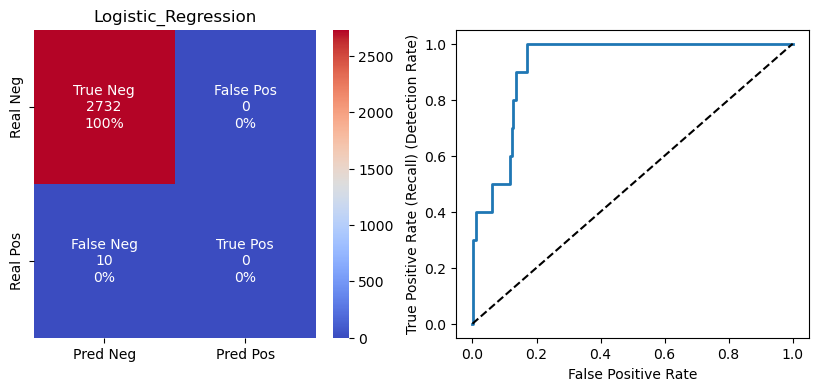

Accuracy of SVM_linear_kernel = 99.64%


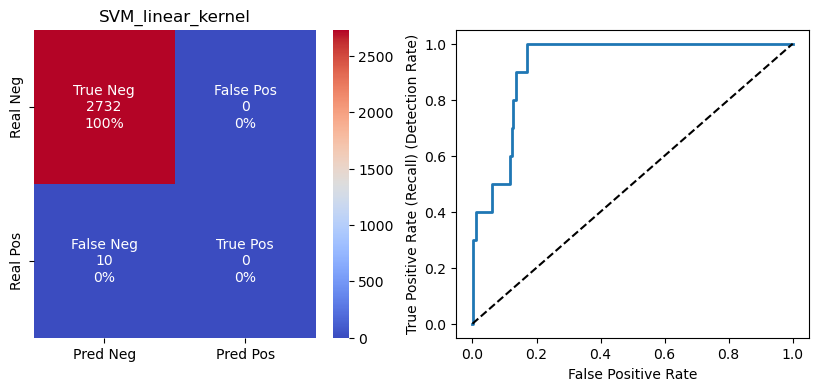

Accuracy of Random_Forest = 99.67%


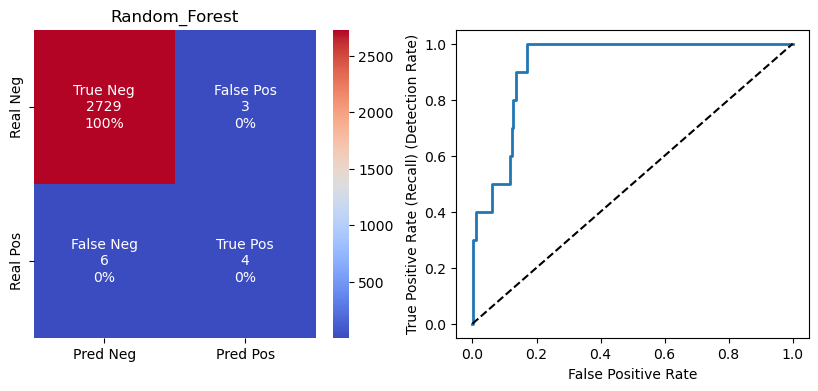

In [128]:
for name, model in models.items():
    print(f"Accuracy of {name} = {model.score(X_test, y_test)*100:.2f}%")

    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    # print(cf_matrix)

    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = [ f'{value:0}' for value in cf_matrix.flatten()]
    group_percentages = [f'{value*100:.0f}%' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [ f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages) ]
    labels = np.asarray(labels).reshape(2,2)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="coolwarm", center = np.sum(cf_matrix)/2, xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["Real Neg", "Real Pos"], ax=ax[0])
    ax[0].set_title(name)

    y_scores = cross_val_predict(clf_lr, X_test, y_test, cv=3, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    
    roc_curve_params[name] = [ fpr, tpr, thresholds ]

    # fig, ax = plt.subplots()

    ax[1].plot(fpr, tpr, linewidth=2)
    ax[1].plot([0,1], [0,1], 'k--')
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate (Recall) (Detection Rate)")
    plt.show()

### NN

In [130]:
import tensorflow as tf
from tensorflow.keras import layers

In [132]:
input_shape = X.shape[0]

model = tf.keras.Sequential(
    [
    layers.Input(shape=(17,)),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=1)
    ]
)

2023-09-12 17:13:11.123107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 17:13:11.123759: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [133]:
model.compile(
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

In [134]:
epochs = 10
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs)

Epoch 1/10
343/343 [==============================] - 6s 13ms/step - loss: 0.0424 - binary_accuracy: 0.9881 - val_loss: 0.0207 - val_binary_accuracy: 0.9964
Epoch 2/10
343/343 [==============================] - 5s 15ms/step - loss: 0.0168 - binary_accuracy: 0.9965 - val_loss: 0.0188 - val_binary_accuracy: 0.9964
Epoch 3/10
343/343 [==============================] - 5s 14ms/step - loss: 0.0155 - binary_accuracy: 0.9964 - val_loss: 0.0187 - val_binary_accuracy: 0.9964
Epoch 4/10
343/343 [==============================] - 5s 15ms/step - loss: 0.0143 - binary_accuracy: 0.9965 - val_loss: 0.0195 - val_binary_accuracy: 0.9964
Epoch 5/10
343/343 [==============================] - 5s 13ms/step - loss: 0.0131 - binary_accuracy: 0.9965 - val_loss: 0.0212 - val_binary_accuracy: 0.9971
Epoch 6/10
343/343 [==============================] - 5s 14ms/step - loss: 0.0126 - binary_accuracy: 0.9965 - val_loss: 0.0211 - val_binary_accuracy: 0.9971
Epoch 7/10
343/343 [==============================] - 5s 1

In [138]:
# calcul du score

y_pred = model(X_test)

# print(f"Accuracy of {name} = {model.score(X_test, y_test)*100:.2f}%")

In [ ]:
    # y_pred = model.predict(X_test)
    # cf_matrix = confusion_matrix(y_test, y_pred)

    # # print(cf_matrix)

    # group_names = ["True Neg","False Pos","False Neg","True Pos"]
    # group_counts = [ f'{value:0}' for value in cf_matrix.flatten()]
    # group_percentages = [f'{value*100:.0f}%' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    # labels = [ f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages) ]
    # labels = np.asarray(labels).reshape(2,2)
    
    # fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    # sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="coolwarm", center = np.sum(cf_matrix)/2, xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["Real Neg", "Real Pos"], ax=ax[0])
    # ax[0].set_title(name)

    # y_scores = cross_val_predict(clf_lr, X_test, y_test, cv=3, method="predict_proba")
    # fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    
    # roc_curve_params[name] = [ fpr, tpr, thresholds ]

    # # fig, ax = plt.subplots()

    # ax[1].plot(fpr, tpr, linewidth=2)
    # ax[1].plot([0,1], [0,1], 'k--')
    # ax[1].set_xlabel("False Positive Rate")
    # ax[1].set_ylabel("True Positive Rate (Recall) (Detection Rate)")
    # plt.show()